# SANS simulations

Choosing an experimental reference frame with the beam incoming aligned and polarised along the $z$ direction, the non-polarised SANS cross section is 
\begin{equation} \label{eq:C7:SANS}
    \frac{d\Sigma}{d\Omega} \propto \left\lVert \widetilde{M}_x \right\rVert + \left\lVert \widetilde{M}_y \right\rVert .
\end{equation}

### Importing Packages

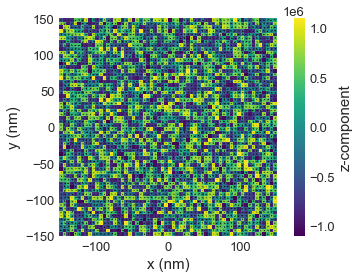

In [72]:
%matplotlib inline
import oommfc as oc
import discretisedfield as df
import micromagneticmodel as mm
import numpy as np
import ubermagutil.units as uu
np.random.seed(1)

region = df.Region(p1=(-150e-9, -150e-9, 0), p2=(150e-9, 150e-9, 20e-9))
mesh = df.Mesh(region=region, cell=(5e-9, 5e-9, 5e-9))

system = mm.System(name='Box2')

system.energy = (mm.Exchange(A=1.6e-11)
                 + mm.DMI(D=4e-3, crystalclass='T') 
                 + mm.UniaxialAnisotropy(K=0.51e6, u=(0, 0, 1)) 
                 + mm.Demag()
                 + mm.Zeeman(H=(0, 0, 2e5)))

Ms = 1.1e6

def m_fun(pos):
    return 2 * np.random.rand(3) - 1

# create system with above geometry and initial magnetisation
system.m = df.Field(mesh, dim=3, value=m_fun, norm=Ms)
system.m.plane('z').mpl()

Running OOMMF (DockerOOMMFRunner) [2021/07/09 12:38]... (17.8 s)


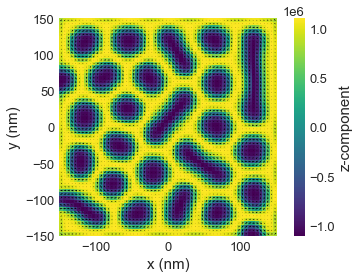

In [73]:
# minimize the energy
md = oc.MinDriver()
md.drive(system)

# Plot relaxed configuration: vectors in z-plane
system.m.plane('z').mpl()

In [74]:
m_p = system.m.integral(direction='z')

sans = (m_p.x.fft2()*m_p.x.fft2().conjugate + m_p.y.fft2()*m_p.y.fft2().conjugate).real

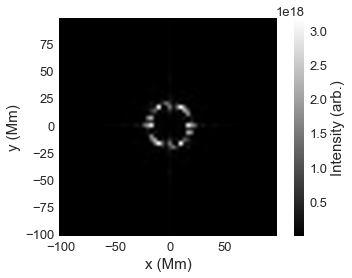

In [75]:
sans.mpl_scalar(cmap='gray',
         interpolation='spline16',
         colorbar_label=r'Intensity (arb.)')

SANS can have other geometries and polarisation of neutrons that I am planning to add. I just need to get my head around the differnt geometries.

\begin{align}
    {\bf Q} &= {\bf q} \times \left[ {\bf q} \times \widetilde{\bf M} \right] \\
    {\bf Q}_{\perp} &= \begin{pmatrix} 
                        -\widetilde{\bf M}_x \\
                        -\widetilde{\bf M}_y \cos^2\theta + \widetilde{\bf M}_z \sin\theta\cos\theta \\
                        \widetilde{\bf M}_y \sin\theta\cos\theta -\widetilde{\bf M}_z \sin2\theta
                       \end{pmatrix}  \\
    {\bf Q}_{\parallel } &= \begin{pmatrix} 
                             -\widetilde{\bf M}_x \sin^2\theta + \widetilde{\bf M}_y \sin\theta\cos\theta \\
                             \widetilde{\bf M}_x \sin\theta\cos\theta - \widetilde{\bf M}_y \cos^2\theta  \\
                             -\widetilde{\bf M}_z
                            \end{pmatrix} 
\end{align}
${\bf q}$ is the unit momentum transfer vector.

\begin{align}
    \frac{d\sum^{\pm \pm}}{d\Omega} &\sim |{\bf Q}_z|^2 \\
    \frac{d\sum^{\pm \mp}}{d\Omega} &\sim |{\bf Q}_x|^2 + |{\bf Q}_y|^2 \mp 
        i\left( {\bf Q}_x {\bf Q}^{\ast}_y - {\bf Q}^{\ast}_x {\bf Q}_y \right)
\end{align}
And

\begin{align}
    \frac{d\sum^{+}}{d\Omega} &= \frac{d\sum^{++}}{d\Omega} + \frac{d\sum^{+-}}{d\Omega} \\
    \frac{d\sum^{-}}{d\Omega} &= \frac{d\sum^{--}}{d\Omega} + \frac{d\sum^{-+}}{d\Omega} \\
    \frac{d\sum}{d\Omega} &= \frac{1}{2} \left( \frac{d\sum^{+}}{d\Omega} + \frac{d\sum^{-}}{d\Omega} \right) \\
    \frac{d\sum}{d\Omega} &= \frac{1}{2} \left( \frac{d\sum^{++}}{d\Omega} + \frac{d\sum^{+-}}{d\Omega} + 
                            \frac{d\sum^{--}}{d\Omega} + \frac{d\sum^{-+}}{d\Omega} \right)
\end{align}

In [114]:
theta = 0#np.pi/2

m_p_ft = m_p.fft2()
Q_perp = (-m_p_ft.x << 
          -m_p_ft.y*np.cos(theta)**2 + m_p_ft.z*np.cos(theta)*np.sin(theta) << 
          m_p_ft.y*np.cos(theta)*np.sin(theta) - m_p_ft.z*np.sin(theta)**2)

Q_para = (-m_p_ft.x*np.sin(theta)**2 + m_p_ft.y*np.cos(theta)*np.sin(theta) << 
          -m_p_ft.y*np.cos(theta)**2 + m_p_ft.x*np.cos(theta)*np.sin(theta) << 
          m_p_ft.z)

In [125]:
cross_perp_pp = Q_perp.z*Q_perp.z.conjugate
cross_perp_nn = Q_perp.z*Q_perp.z.conjugate
cross_perp_pn = (Q_perp.x*Q_perp.x.conjugate + Q_perp.y*Q_perp.y.conjugate + 
            1j * (Q_perp.x*Q_perp.y.conjugate - Q_perp.x.conjugate*Q_perp.y))
cross_perp_np = (Q_perp.x*Q_perp.x.conjugate + Q_perp.y*Q_perp.y.conjugate - 
            1j * (Q_perp.x*Q_perp.y.conjugate - Q_perp.x.conjugate*Q_perp.y))

In [126]:
p=1/2
sf=1
cross_perp_sanspol = (cross_perp_pp +
                      Q_perp.x*Q_perp.x.conjugate + Q_perp.y*Q_perp.y.conjugate + 
                      1j * (Q_perp.x*Q_perp.y.conjugate - Q_perp.x.conjugate*Q_perp.y) *
                      (2*p-1) * (2*sf-1))

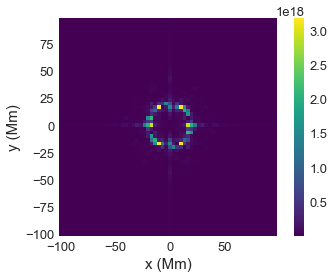

In [127]:
cross_perp_sanspol.real.mpl()

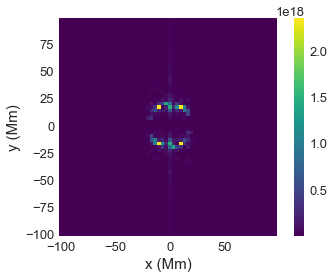

In [103]:
cross_perp_pn.real.mpl()

In [96]:
t_sans = 0.5 * (cross_pp + cross_pn + cross_np + cross_nn)

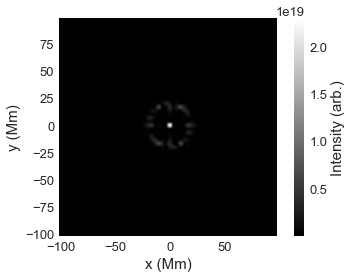

In [97]:
t_sans.real.mpl_scalar(cmap='gray', interpolation='spline16', colorbar_label=r'Intensity (arb.)')

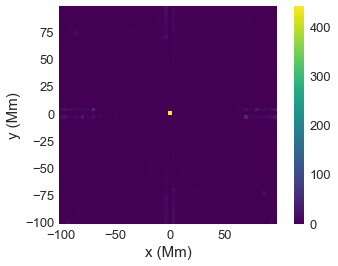

In [81]:
((t_sans-sans)/sans).real.mpl()